In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
#import jax
#jax.config.update('jax_platform_name', 'cpu')

In [1]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.models import NoiseOutsourcingModel, KantorovichGapModel
from entot.models.utils import MixtureNormalSampler
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import scanpy as sc

In [4]:
adata = sc.read("../../../../data/adata_pancreas_2022_processed_new.h5ad")

In [5]:
sc.pp.pca(adata, n_comps=10)

In [15]:
source = adata[adata.obs["sample"]=="E14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["sample"]=="E15.5"].obsm["X_pca"].copy()

In [16]:
kg = KantorovichGapModel(epsilon=0.1, input_dim=10, iterations=5000)

In [17]:
kg(source, target)

100%|██████████| 5000/5000 [54:39<00:00,  1.52it/s]


In [24]:
1

1

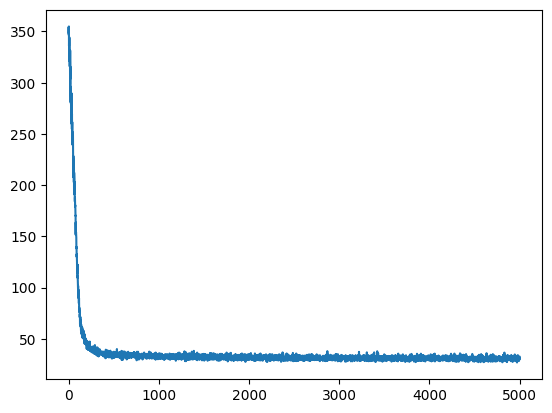

In [21]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["total_loss"])

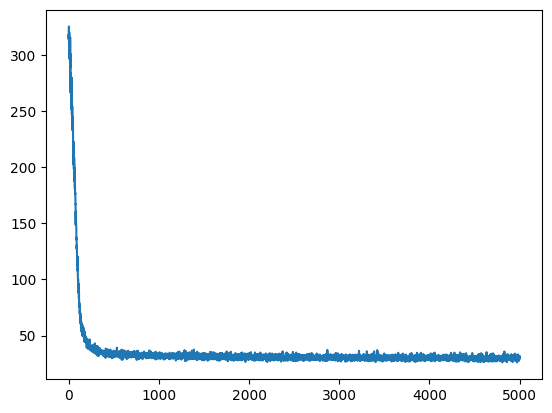

In [22]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])

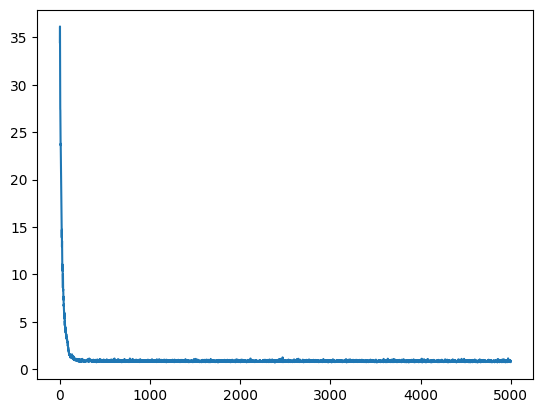

In [23]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["kant_gap"])

In [25]:
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(len(source), 4))

In [36]:
source_with_noise = jnp.concatenate((source, noise), axis=1)

In [37]:
pushed = kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)

In [38]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed, target), axis=0)

In [44]:
del bdata.uns
del bdata.obsp

In [45]:
bdata.obsm

AxisArrays with keys: X_pca, X_pca_wsnn, X_spca_wsnn, X_umap, X_umap_ATAC, X_umap_GEX, X_umap_wsnn, lsi_full, lsi_red, umap, umap_ATAC, umap_GEX, X_pca_result

In [46]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

In [47]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


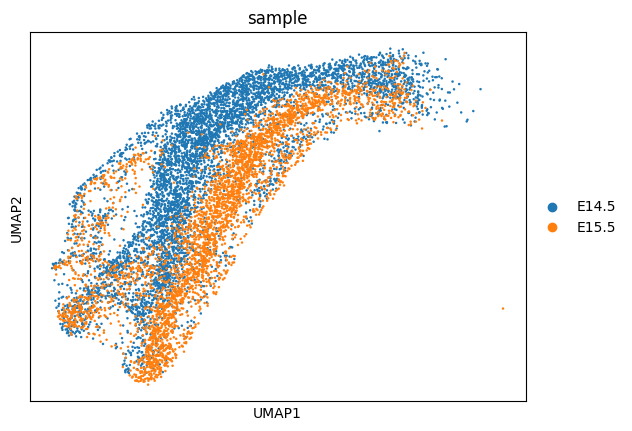

In [48]:
sc.pl.umap(bdata, color="sample")

In [49]:
adata.obsm["X_pca_original"] = np.concatenate((source, target), axis=0)


In [50]:
sc.pp.neighbors(adata, use_rep="X_pca_original")

In [51]:
sc.tl.umap(adata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


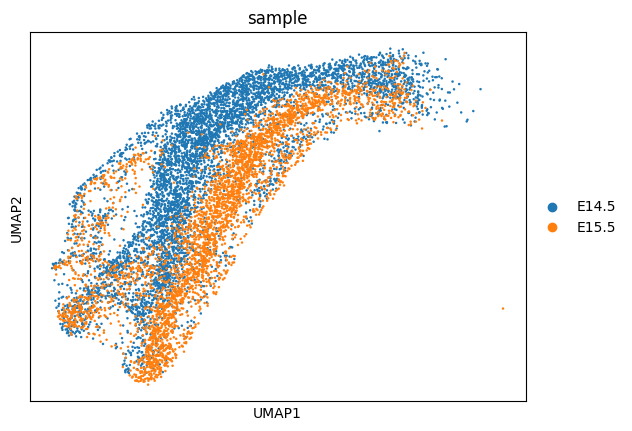

In [53]:
sc.pl.umap(adata, color="sample")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


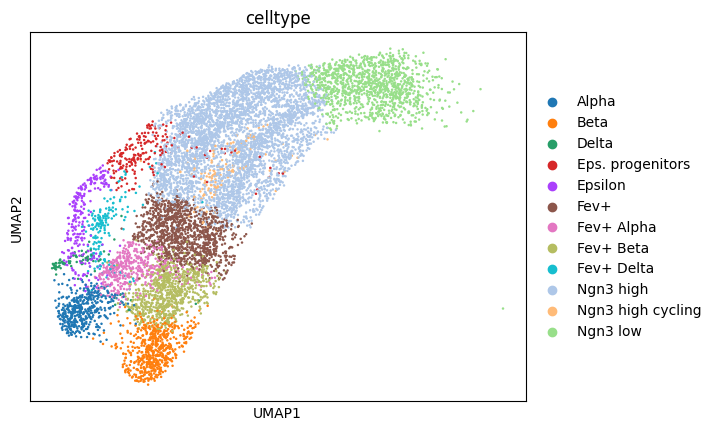

In [54]:
sc.pl.umap(adata, color="celltype")

In [55]:
res = [None] * 15

for i in range(15):
    noise = jax.random.normal(jax.random.PRNGKey(i), shape=(len(source), 4))
    source_with_noise = jnp.concatenate((source, noise), axis=1)
    res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)


In [56]:
samples = jnp.array(res)

In [57]:
samples.shape

(15, 5539, 10)

In [58]:
vars = jnp.var(samples, axis=0)

In [59]:
vars_summed = jnp.sum(vars, axis=1)

In [60]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

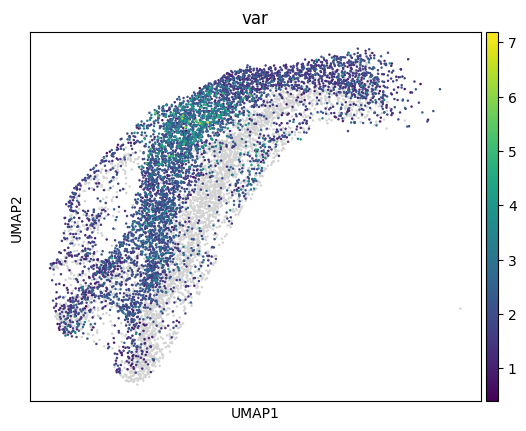

In [61]:
sc.pl.umap(bdata, color="var")

In [62]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Alpha,1.701161
Beta,1.512374
Delta,1.400051
Eps. progenitors,1.872609
Epsilon,1.570571
Fev+,2.026311
Fev+ Alpha,1.760879
Fev+ Beta,1.885538
Fev+ Delta,1.734424


In [73]:
cdata = bdata[~bdata.obs["celltype"].isin(["Acinar", "Ductal", "Tip", "Trunk", "Multipotent", "Ngn3 low EP"])].copy()

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


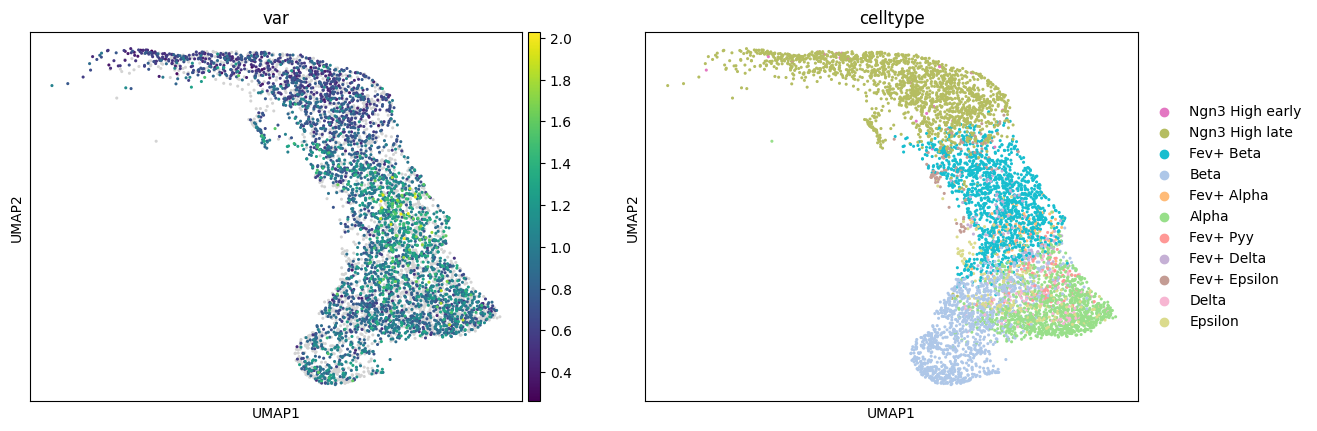

In [75]:
sc.pl.umap(cdata, color=["var", "celltype"])

In [76]:
sc.pp.neighbors(cdata, use_rep="X_pca_result")

In [77]:
sc.tl.umap(cdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


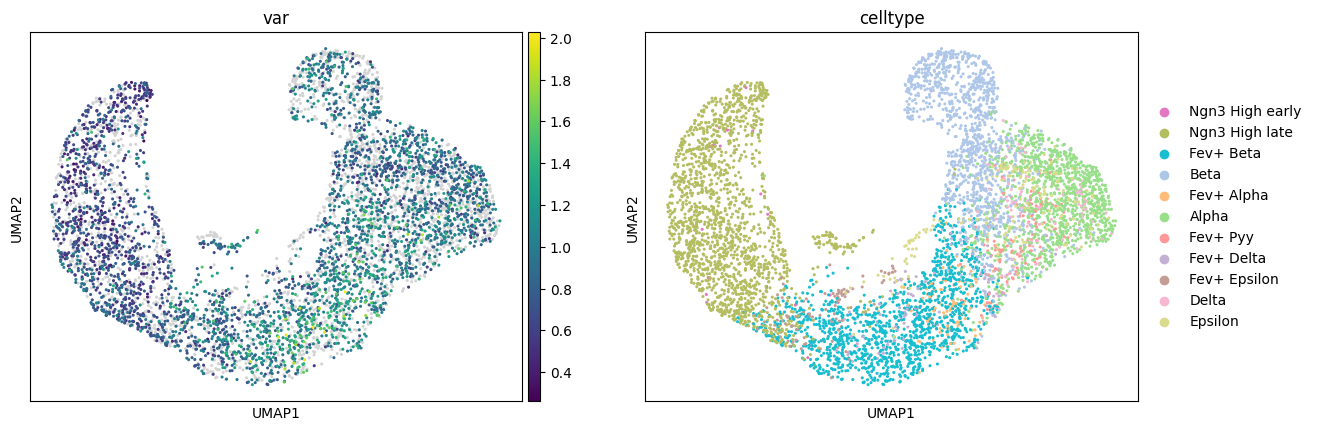

In [79]:
sc.pl.umap(cdata, color=["var", "celltype"])

Variance p(Y|X=0.5) is 0.10


<Axes: ylabel='Density'>

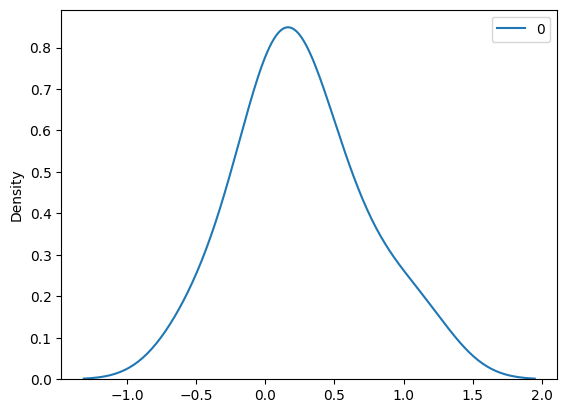

In [19]:
sample_05 = sm.sample(jnp.array([0.5]))
print(f"Variance p(Y|X=0.5) is {jnp.var(sample_05):.2f}")
sns.kdeplot(sample_0)